In [ ]:
import sys

sys.path.append('../../')

import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras.backend as K
from Pipeline.Multi_task.soft_parameter_sharing import ConstrainedMTL
from keras.layers import Dense, Conv1D, MaxPool1D, Lambda
from keras import Input, Model
from keras import Sequential

from Pipeline.tf_dataset_builder import DatasetBuilderRaw
from Pipeline.evaluation import detection_report
from Pipeline.tf_lite_utils import convert_tf_lite_mtl, predict_tflite_mtl, convert_tf_lite, compare_size
from Pipeline.evaluation import plot_confusion_matrix

In [2]:
# Set seed for experiment reproducibility
seed = 1
tf.random.set_seed(seed)

In [3]:
# Define paths to model files
MODELS_DIR = '../../Models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'sps_model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'sps_model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'sps_model.tflite'

In [4]:
class_dict = {
    'Background': 0,
    'Big mandibles': 1,
    'Small mandibles': 2,
}

In [5]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
patience = 8
gamma = 0.5

In [6]:
# Load the data: raw extraction
DatasetBuilder = DatasetBuilderRaw(
    #dataset_dir="../../Dataset/Generated dataset/Deployment/unstandardized/50ms/**/*.wav",
    dataset_dir="../../Dataset/Final dataset/Generation/Generated dataset/**/*.wav",
    batch_size=batch_size,
    class_dict=class_dict,
    augment=False,
    balanced=False,
    multi_task=True,
    normalize=True,
    seed=seed,
    sample_rate=44100
)
train_dataset, val_dataset, test_dataset = DatasetBuilder.build(val_split=0.2, test_split=0.2)

In [7]:
input_shape = test_dataset[0][0].shape
input_shape

(2205, 1)

In [8]:
input_layer = Input(shape=input_shape)

detection_backbone = Sequential([
    Conv1D(filters=8, kernel_size=80, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Lambda(lambda x: K.mean(x, axis=1)),
    Dense(units=32, activation='relu'),
])

classification_backbone = Sequential([
    Conv1D(filters=8, kernel_size=80, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Lambda(lambda x: K.mean(x, axis=1)),
    Dense(units=32, activation='relu'),
])

latent = ConstrainedMTL([detection_backbone, classification_backbone], l1_regularizer=0.5, l2_regularizer=0.5)(input_layer)

detection_head = Sequential([
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
detection_head._name = 'detection'

classification_head = Sequential([
    Dense(32, activation='relu'),
    Dense(len(class_dict), activation='softmax'),
])
classification_head._name = 'classification'

output1 = detection_head(latent[0])
output2 = classification_head(latent[1])

multitask_model = Model(inputs=input_layer, outputs=[output1, output2])

In [9]:
multitask_model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2205, 1)]    0           []                               
                                                                                                  
 constrained_mtl (ConstrainedMT  [(None, 32),        2672        ['input_1[0][0]']                
 L)                              (None, 32)]                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| sequential (Sequential)      (None, 32)           1336        []                               |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| conv1d (Conv1D)            (None, 2205, 8)      648         []                             

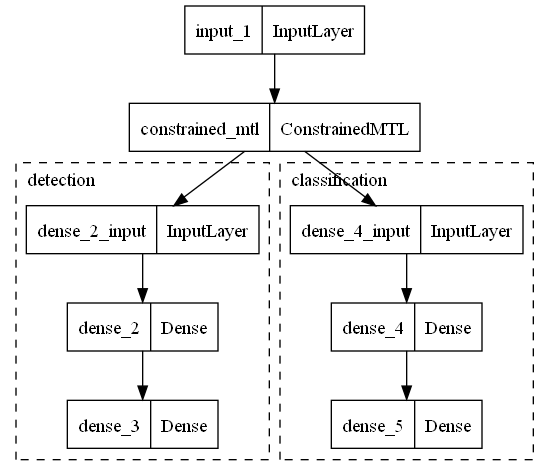

In [10]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
tf.keras.utils.plot_model(multitask_model, expand_nested=True)

In [10]:
loss1 = tf.keras.losses.BinaryCrossentropy()
loss2 = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

losses = {
    'detection': loss1,
    'classification': loss2
}

loss_weights = {
    'detection': gamma,
    'classification': 1 - gamma
}

metrics = ['accuracy']

multitask_model.compile(
    optimizer=optimizer,
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics,
)

In [11]:
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(verbose=1, patience=patience)

history = multitask_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/100
30/30 [==============================] - 5s 85ms/step - loss: 1.3468 - detection_loss: 0.6664 - classification_loss: 1.0880 - detection_accuracy: 0.6411 - classification_accuracy: 0.3448 - val_loss: 1.2695 - val_detection_loss: 0.6364 - val_classification_loss: 1.0863 - val_detection_accuracy: 0.6708 - val_classification_accuracy: 0.3875 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 2s 75ms/step - loss: 1.2187 - detection_loss: 0.6445 - classification_loss: 1.0720 - detection_accuracy: 0.6583 - classification_accuracy: 0.4167 - val_loss: 1.1612 - val_detection_loss: 0.6276 - val_classification_loss: 1.0654 - val_detection_accuracy: 0.6708 - val_classification_accuracy: 0.4375 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 2s 70ms/step - loss: 1.1208 - detection_loss: 0.6377 - classification_loss: 1.0443 - detection_accuracy: 0.6583 - classification_accuracy: 0.4411 - val_loss: 1.0727 - val_detection_loss: 0.6220 - val_classification_lo

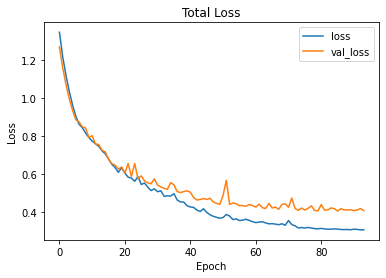

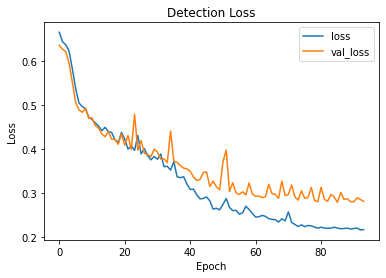

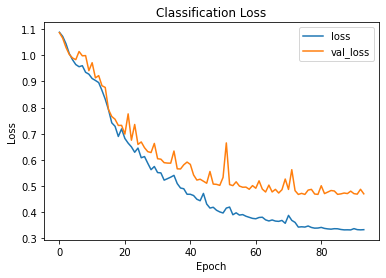

In [12]:
metrics = history.history
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.title('Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['detection_loss'], metrics['val_detection_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['classification_loss'], metrics['val_classification_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [13]:
test_features = test_dataset[0]
predictions = multitask_model.predict(test_features, verbose=1)

y_pred = np.rint(predictions[0])
y_true = test_dataset[1]['detection']

detection_report(y_true, y_pred.flatten())

19/19 [==============================] - 0s 10ms/step

Evaluation on the test set:
False alarm prob: 20.43%
Miss detection prob: 13.53%
Number of False Positives: 38
Number of False Negatives: 56
Detector f1-score is 88.395062%

Other Metrics:
Detector accuracy is 84.333333%
Detector precision is 90.404040%
Detector recall is 86.473430%


Classification test set accuracy: 76%


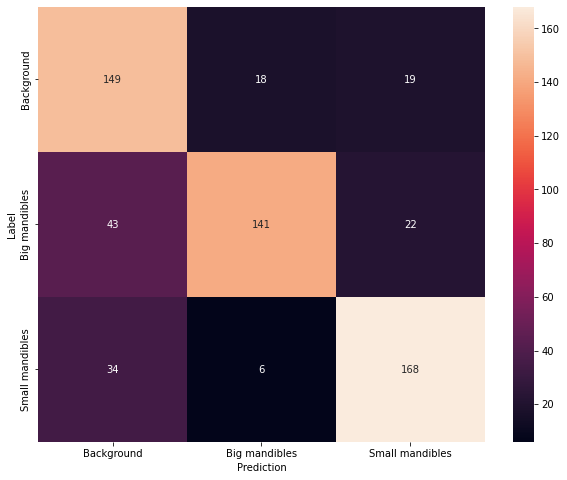

In [14]:
y_pred = np.argmax(predictions[1], axis=1)
y_true = test_dataset[1]['classification']

test_acc = accuracy_score(y_true=y_true, y_pred=y_pred)
print(f'Classification test set accuracy: {test_acc:.0%}')
plot_confusion_matrix(list(class_dict.keys()), y_true, y_pred)

In [15]:
multitask_model.save(MODEL_TF)
convert_tf_lite(MODEL_TF, MODEL_NO_QUANT_TFLITE)

Float model is 35836 bytes


In [16]:
def representative_dataset():
    for feature, label in train_dataset.take(100):
        yield {
            "input_1": feature.numpy(),
            "detection": label['detection'].numpy(),
            "classification": label['classification'].numpy(),
        }

In [17]:
# Define the input and output details for TensorFlow Lite
input_details = multitask_model.input
output_details = [multitask_model.output[0], multitask_model.output[1]]
# Convert to TensorFlow Lite model
convert_tf_lite_mtl(MODEL_TF, MODEL_TFLITE, representative_dataset, output_details)

Quantized model is 25056 bytes


In [23]:
input_details

<KerasTensor: shape=(None, 2205, 1) dtype=float32 (created by layer 'input_1')>

In [18]:
compare_size(multitask_model, batch_size, MODEL_NO_QUANT_TFLITE, MODEL_TFLITE)

,Size,
Model,,
TensorFlow,598264 bytes,
TensorFlow Lite,35836 bytes,(reduced by 562428 bytes)
TensorFlow Lite Quantized,25056 bytes,(reduced by 10780 bytes)


In [19]:
y_pred_det, y_pred_class = predict_tflite_mtl(MODEL_TFLITE, test_features)

In [20]:
detection_report(test_dataset[1]['detection'], y_pred_det.flatten())


Evaluation on the test set:
False alarm prob: 25.27%
Miss detection prob: 11.11%
Number of False Positives: 47
Number of False Negatives: 46
Detector f1-score is 88.781665%

Other Metrics:
Detector accuracy is 84.500000%
Detector precision is 88.674699%
Detector recall is 88.888889%


              precision    recall  f1-score   support

           0     0.6837    0.7204    0.7016       186
           1     0.7929    0.7621    0.7772       206
           2     0.8010    0.7933    0.7971       208

    accuracy                         0.7600       600
   macro avg     0.7592    0.7586    0.7586       600
weighted avg     0.7618    0.7600    0.7607       600



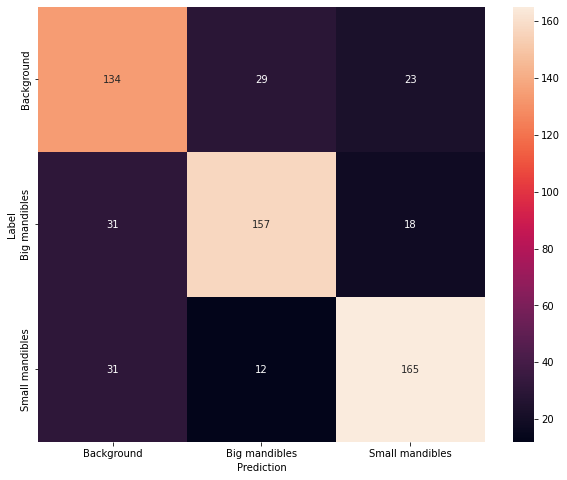

In [21]:
print(classification_report(test_dataset[1]['classification'], y_pred_class, digits=4))
plot_confusion_matrix(list(class_dict.keys()), test_dataset[1]['classification'], y_pred_class)